<a href="https://colab.research.google.com/github/Howl06/classify_project_final/blob/main/metric_learning/TripletMarginLossfor_mydateset_change_mobilenetbone_128_400.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
cd /content/drive/MyDrive/model/deep-learning-for-image-processing-master/data_set/project_data

/content/drive/MyDrive/model/deep-learning-for-image-processing-master/data_set/project_data


In [17]:
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import mobilenet_v3_large as mobilenet_v3
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import datasets, transforms
import numpy as np
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout2d(0.25)
#         self.dropout2 = nn.Dropout2d(0.5)
#         self.gab = nn.AdaptiveAvgPool2d(1)
#         self.fc1 = nn.Linear(64, 128)

#     def forward(self, x):
#         x = self.conv1(x) # batchsize 3 224 224  -> batchsize 32 224 224 
#         x = F.relu(x)
#         x = self.conv2(x) # batchsize 32 224 224  -> batchsize 64 224 224 
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2) # batchsize 64 224 224 -> batchsize 64 112 112
#         x = self.dropout1(x)
#         x = self.gab(x)     # batchsize 64 112 112 -> batchsize 64 1
#         x = torch.flatten(x, 1) # batchsize 64 1 -> batchsize 64
#         x = self.fc1(x)
#         return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(
                    epoch, batch_idx, loss, mining_func.num_triplets
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
# def test(train_set, test_set, model, accuracy_calculator):
#     train_embeddings, train_labels = get_all_embeddings(train_set, model)
#     test_embeddings, test_labels = get_all_embeddings(test_set, model)
#     train_labels = train_labels.squeeze(1)
#     test_labels = test_labels.squeeze(1)
#     print("Computing accuracy")
#     accuracies = accuracy_calculator.get_accuracy(
#         test_embeddings, test_labels, train_embeddings, train_labels, False
#     )
#     print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

def test(train_set, test_set, model):
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    test_labels = test_labels.squeeze(1)
    near_neighbours_per_example = 5
    # 計算圖片兩兩間的內積
    gram_matrix = np.einsum("ae,be->ab", test_embeddings, test_embeddings)
    # 計算每一筆資料相似度排序最高的5筆結果 (小->大)
    # 最大值就是自己本身 (100%相似)
    near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]
    total_valid_num = len(near_neighbours)
    total_right = 0
    for i in range(total_valid_num):
        count = 0
        for index in near_neighbours[i][:-2]:
            if test_labels[near_neighbours[i][-1]] == test_labels[index]:
                count += 1
        if count > 2:
            total_right += 1
    accuracy = total_right / total_valid_num
    print("Computing accuracy")
    print("Test accuracy = {}".format(accuracy))
    return accuracy


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

transform = transforms.Compose(
    [transforms.Resize(224+32),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5232674, 0.49784118, 0.42335856], [0.24051566, 0.23351395, 0.23727049])]
)

batch_size = 128
num_epochs = 50


#　dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
train_dataset = datasets.ImageFolder(root="./train/",
                                         transform=transform)
valid_dataset = datasets.ImageFolder(root="./val/",
                                         transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
model = torch.load("/content/drive/MyDrive/metric_learning/ml_128_100.pt",map_location=device)
# model = mobilenet_v3(pretrained=True)
# num_ftrs = model.classifier[0].in_features
# model.classifier = nn.Linear(num_ftrs, 128)
print(model)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)


### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1, device=torch.device("cpu"))
### pytorch-metric-learning stuff ###




using cpu device.
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1),

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    # test(train_dataset, valid_dataset, model, accuracy_calculator)
    accuracy = test(train_dataset, valid_dataset, model)
    bestacc = 0
    if accuracy > bestacc:
        torch.save(model, "/content/drive/MyDrive/metric_learning/ml.pt")
        bestacc = accuracy
# epoch 24

Epoch 1 Iteration 0: Loss = 0.09356927126646042, Number of mined triplets = 2264
Epoch 1 Iteration 20: Loss = 0.08916216343641281, Number of mined triplets = 251


100%|██████████| 21/21 [01:34<00:00,  4.51s/it]


Computing accuracy
Test accuracy = 0.1181959564541213
Epoch 2 Iteration 0: Loss = 0.08873924612998962, Number of mined triplets = 2883
Epoch 2 Iteration 20: Loss = 0.08293070644140244, Number of mined triplets = 245


100%|██████████| 21/21 [01:33<00:00,  4.47s/it]


Computing accuracy
Test accuracy = 0.12441679626749612
Epoch 3 Iteration 0: Loss = 0.09112902730703354, Number of mined triplets = 1660
Epoch 3 Iteration 20: Loss = 0.08037368953227997, Number of mined triplets = 147


100%|██████████| 21/21 [01:32<00:00,  4.39s/it]


Computing accuracy
Test accuracy = 0.06998444790046657
Epoch 4 Iteration 0: Loss = 0.08654418587684631, Number of mined triplets = 1150
Epoch 4 Iteration 20: Loss = 0.06822004169225693, Number of mined triplets = 70


100%|██████████| 21/21 [01:36<00:00,  4.59s/it]


Computing accuracy
Test accuracy = 0.15707620528771385
Epoch 5 Iteration 0: Loss = 0.08713200688362122, Number of mined triplets = 1348
Epoch 5 Iteration 20: Loss = 0.07817544788122177, Number of mined triplets = 142


100%|██████████| 21/21 [01:32<00:00,  4.43s/it]


Computing accuracy
Test accuracy = 0.2690513219284603
Epoch 6 Iteration 0: Loss = 0.07662776112556458, Number of mined triplets = 606
Epoch 6 Iteration 20: Loss = 0.07268368452787399, Number of mined triplets = 147


100%|██████████| 21/21 [01:35<00:00,  4.53s/it]


Computing accuracy
Test accuracy = 0.19129082426127528
Epoch 7 Iteration 0: Loss = 0.07380663603544235, Number of mined triplets = 1185
Epoch 7 Iteration 20: Loss = 0.08100122958421707, Number of mined triplets = 108


100%|██████████| 21/21 [01:34<00:00,  4.50s/it]


Computing accuracy
Test accuracy = 0.2317262830482115
Epoch 8 Iteration 0: Loss = 0.07584235817193985, Number of mined triplets = 823
Epoch 8 Iteration 20: Loss = 0.08776125311851501, Number of mined triplets = 182


100%|██████████| 21/21 [01:33<00:00,  4.45s/it]


Computing accuracy
Test accuracy = 0.2208398133748056
Epoch 9 Iteration 0: Loss = 0.06741337478160858, Number of mined triplets = 893
Epoch 9 Iteration 20: Loss = 0.0776895210146904, Number of mined triplets = 156


100%|██████████| 21/21 [01:33<00:00,  4.47s/it]


Computing accuracy
Test accuracy = 0.17418351477449456
Epoch 10 Iteration 0: Loss = 0.07390883564949036, Number of mined triplets = 351
Epoch 10 Iteration 20: Loss = 0.08052507042884827, Number of mined triplets = 164


100%|██████████| 21/21 [01:36<00:00,  4.61s/it]


Computing accuracy
Test accuracy = 0.2379471228615863
Epoch 11 Iteration 0: Loss = 0.08167769014835358, Number of mined triplets = 869
Epoch 11 Iteration 20: Loss = 0.0816417708992958, Number of mined triplets = 253


100%|██████████| 21/21 [01:32<00:00,  4.41s/it]


Computing accuracy
Test accuracy = 0.16951788491446346
Epoch 12 Iteration 0: Loss = 0.0815964862704277, Number of mined triplets = 1075
Epoch 12 Iteration 20: Loss = 0.07711327821016312, Number of mined triplets = 169


100%|██████████| 21/21 [01:32<00:00,  4.41s/it]


Computing accuracy
Test accuracy = 0.09797822706065319
Epoch 13 Iteration 0: Loss = 0.06645621359348297, Number of mined triplets = 817
Epoch 13 Iteration 20: Loss = 0.07311825454235077, Number of mined triplets = 79


100%|██████████| 21/21 [01:40<00:00,  4.78s/it]


Computing accuracy
Test accuracy = 0.24572317262830481
Epoch 14 Iteration 0: Loss = 0.0795801505446434, Number of mined triplets = 577
Epoch 14 Iteration 20: Loss = 0.0732458159327507, Number of mined triplets = 161


100%|██████████| 21/21 [01:36<00:00,  4.58s/it]


Computing accuracy
Test accuracy = 0.37947122861586313
Epoch 15 Iteration 0: Loss = 0.06859935075044632, Number of mined triplets = 543
Epoch 15 Iteration 20: Loss = 0.08207403123378754, Number of mined triplets = 146


100%|██████████| 21/21 [01:34<00:00,  4.49s/it]


Computing accuracy
Test accuracy = 0.3701399688958009
Epoch 16 Iteration 0: Loss = 0.07285086065530777, Number of mined triplets = 573
Epoch 16 Iteration 20: Loss = 0.08315939456224442, Number of mined triplets = 335


100%|██████████| 21/21 [01:35<00:00,  4.54s/it]


Computing accuracy
Test accuracy = 0.4758942457231726
Epoch 17 Iteration 0: Loss = 0.07917226850986481, Number of mined triplets = 484
Epoch 17 Iteration 20: Loss = 0.07499268651008606, Number of mined triplets = 29


100%|██████████| 21/21 [01:37<00:00,  4.66s/it]


Computing accuracy
Test accuracy = 0.37169517884914466
Epoch 18 Iteration 0: Loss = 0.07613634318113327, Number of mined triplets = 676
Epoch 18 Iteration 20: Loss = 0.08988624066114426, Number of mined triplets = 129


100%|██████████| 21/21 [01:37<00:00,  4.64s/it]


Computing accuracy
Test accuracy = 0.3499222395023328
Epoch 19 Iteration 0: Loss = 0.07457292824983597, Number of mined triplets = 879
Epoch 19 Iteration 20: Loss = 0.09123880416154861, Number of mined triplets = 198


100%|██████████| 21/21 [01:34<00:00,  4.48s/it]


Computing accuracy
Test accuracy = 0.432348367029549
Epoch 20 Iteration 0: Loss = 0.08397885411977768, Number of mined triplets = 772
Epoch 20 Iteration 20: Loss = 0.061401985585689545, Number of mined triplets = 51


100%|██████████| 21/21 [01:34<00:00,  4.49s/it]


Computing accuracy
Test accuracy = 0.3094867807153966
Epoch 21 Iteration 0: Loss = 0.07000350207090378, Number of mined triplets = 302
Epoch 21 Iteration 20: Loss = 0.07185520231723785, Number of mined triplets = 87


100%|██████████| 21/21 [01:36<00:00,  4.60s/it]


Computing accuracy
Test accuracy = 0.3856920684292379
Epoch 22 Iteration 0: Loss = 0.06661141663789749, Number of mined triplets = 231
Epoch 22 Iteration 20: Loss = 0.07747351378202438, Number of mined triplets = 46


100%|██████████| 21/21 [01:36<00:00,  4.61s/it]


Computing accuracy
Test accuracy = 0.46500777604976673
Epoch 23 Iteration 0: Loss = 0.07784871757030487, Number of mined triplets = 193
Epoch 23 Iteration 20: Loss = 0.08573254197835922, Number of mined triplets = 149


100%|██████████| 21/21 [01:32<00:00,  4.38s/it]


Computing accuracy
Test accuracy = 0.26283048211508553
Epoch 24 Iteration 0: Loss = 0.07700086385011673, Number of mined triplets = 545
Epoch 24 Iteration 20: Loss = 0.0794195830821991, Number of mined triplets = 75


100%|██████████| 21/21 [01:33<00:00,  4.47s/it]


Computing accuracy
Test accuracy = 0.5147744945567652
Epoch 25 Iteration 0: Loss = 0.06768317520618439, Number of mined triplets = 210


In [ ]:
from sklearn import manifold

model = torch.load("/content/drive/MyDrive/metric_learning/ml.pt",map_location=device)
# model = mobilenet_v3(pretrained=True)
# num_ftrs = model.classifier[0].in_features
# model.classifier = nn.Linear(num_ftrs, 128)
model.to(device)
train_embeddings, train_labels = get_all_embeddings(train_dataset, model)

100%|██████████| 83/83 [10:27<00:00,  7.56s/it]


In [19]:
from sklearn import manifold

model = torch.load("/content/drive/MyDrive/metric_learning/ml_128_400.pt",map_location=device)
# model = mobilenet_v3(pretrained=True)
# num_ftrs = model.classifier[0].in_features
# model.classifier = nn.Linear(num_ftrs, 128)
model.to(device)
train_embeddings, train_labels = get_all_embeddings(valid_dataset, model)

100%|██████████| 21/21 [02:40<00:00,  7.65s/it]


In [20]:
from collections import defaultdict

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(valid_dataset):
    class_idx_to_test_idxs[y[1]].append(y_test_idx)


In [21]:
N_SAMPLES = 2628

In [22]:
N_SAMPLES = 643

In [23]:
x_tsne = manifold.TSNE(n_components=2, 
                       init='random', 
                       random_state=5566, 
                       verbose=1).fit_transform(train_embeddings[:N_SAMPLES])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 643 samples in 0.001s...
[t-SNE] Computed neighbors for 643 samples in 0.212s...
[t-SNE] Computed conditional probabilities for sample 643 / 643
[t-SNE] Mean sigma: 0.224815
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.999554
[t-SNE] KL divergence after 1000 iterations: 0.292152


In [24]:
x_tsne.shape

(643, 2)

In [25]:
train_labels = torch.squeeze(train_labels)

<ipython-input-26-5de5abfbdb4b>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", 27)


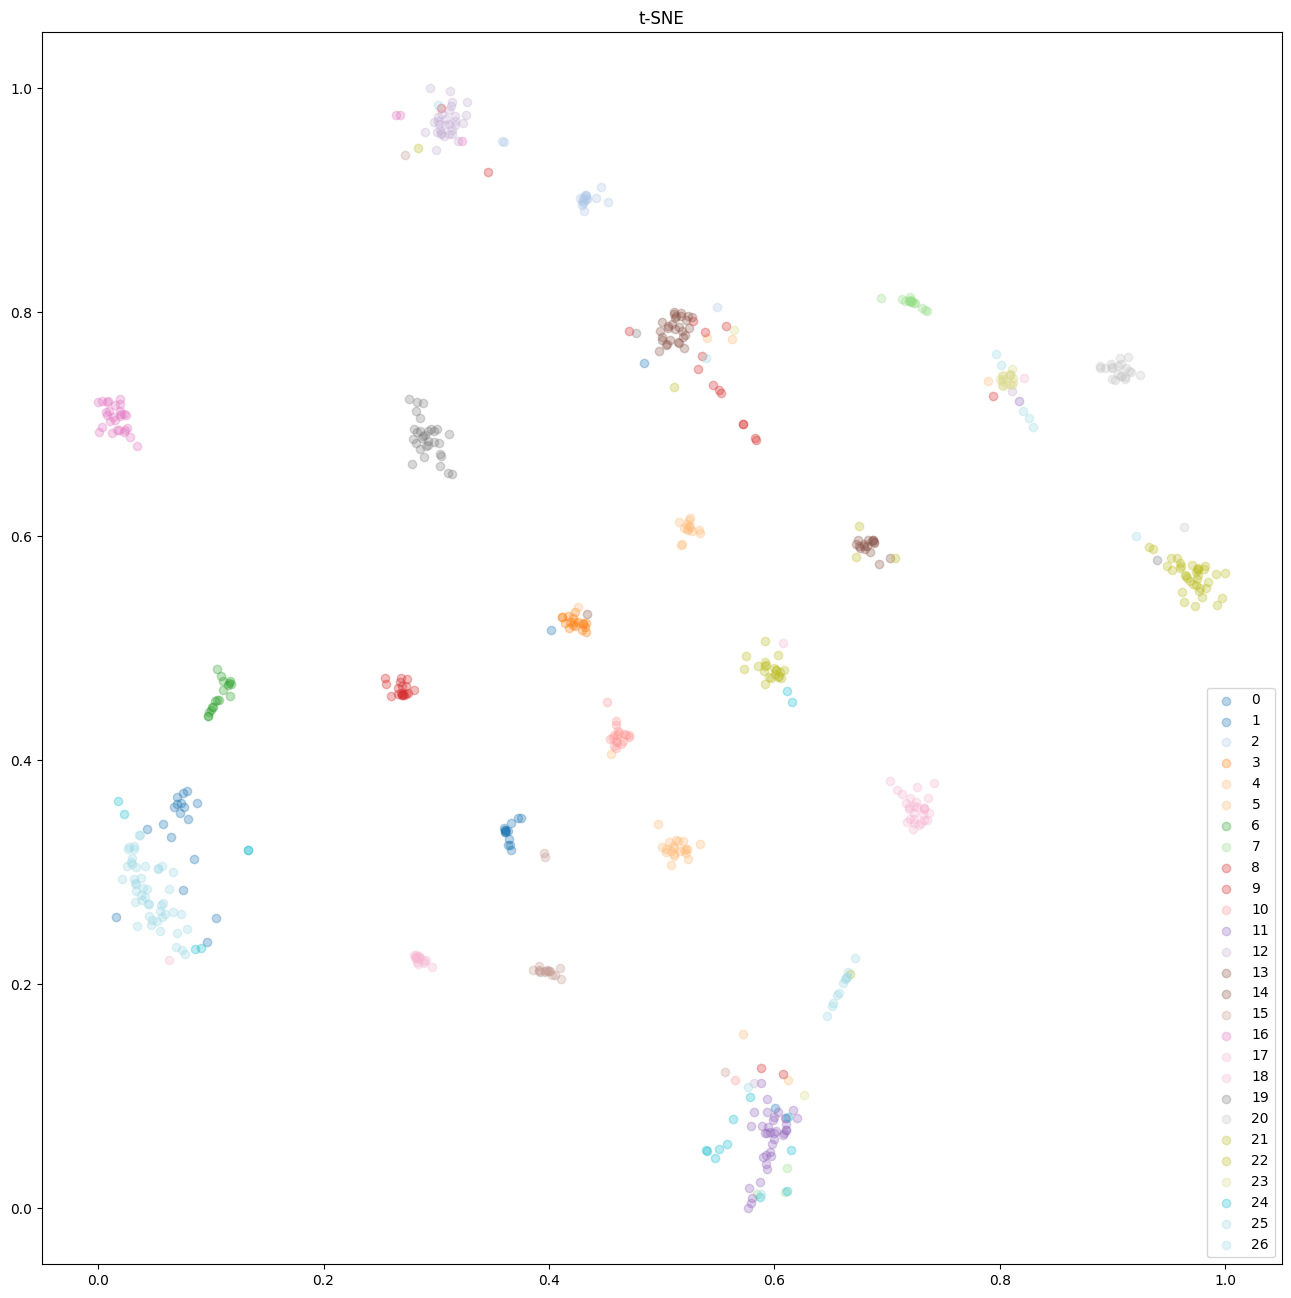

In [26]:
import matplotlib.pyplot as plt
# normalize
x_min, x_max = x_tsne.min(0), x_tsne.max(0)
x_norm = (x_tsne - x_min) / (x_max - x_min)

plt.figure(figsize=(16, 16))
cmap = plt.cm.get_cmap("tab20", 27)

for digit in range(27):
    idx = train_labels[:N_SAMPLES] == digit
    plt.scatter(x_norm[idx, 0], 
                x_norm[idx, 1], 
                color=cmap(digit), 
                label=digit, 
                alpha=0.3)

plt.title("t-SNE")
plt.legend()
plt.show()

## Testing

1. 計算整個test_set的圖片embedding
2. 計算test圖片兩兩間的相似度 

In [27]:
valid_dataset = datasets.ImageFolder(root="./val/",transform=transforms.Resize((50, 50)))
x_test_raw = valid_dataset

In [28]:
embeddings, y_test = train_embeddings, train_labels

In [29]:
near_neighbours_per_example = 5


# 計算圖片兩兩間的內積
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
# 計算每一筆資料相似度排序最高的5筆結果 (小->大)
# 最大值就是自己本身 (100%相似)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

In [30]:
embeddings.shape, gram_matrix.shape, near_neighbours.shape

(torch.Size([643, 128]), (643, 643), (643, 6))

In [31]:
for i in range(50):
    print(near_neighbours[i])
    count = 0
    for index in near_neighbours[i][:-2]:
        if y_test[near_neighbours[i][-1]] == y_test[index]:
            count += 1
        print(y_test[index])
        print(y_test[near_neighbours[i][-1]])
    if count > 2:
        print("1", count)
    else:
        print("0", count)

[12  2 16 13  6  0]
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
1 4
[612 618 600 609 602   1]
tensor(26)
tensor(0)
tensor(26)
tensor(0)
tensor(26)
tensor(0)
tensor(26)
tensor(0)
0 0
[16  6 17  0 13  2]
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
1 4
[621 635 618 607 596   3]
tensor(26)
tensor(0)
tensor(26)
tensor(0)
tensor(26)
tensor(0)
tensor(26)
tensor(0)
0 0
[621 629 613 606  16   4]
tensor(26)
tensor(0)
tensor(26)
tensor(0)
tensor(26)
tensor(0)
tensor(26)
tensor(0)
0 0
[10  0 12  9 13  5]
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
1 4
[607  14  13  16   0   6]
tensor(26)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
1 3
[ 11   4 132   9 620   7]
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(7)
tensor(0)
tensor(0)
tensor(0)
1 3
[ 11 611  10  14   1   8]
tensor(0)
tensor(0)
tensor(26)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
1 3
[ 6 16  4 13  

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay

def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx])).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage

column 0: 原始查詢圖片

column 1~5: 資料庫中最接近的圖片 以相似度排序大->小

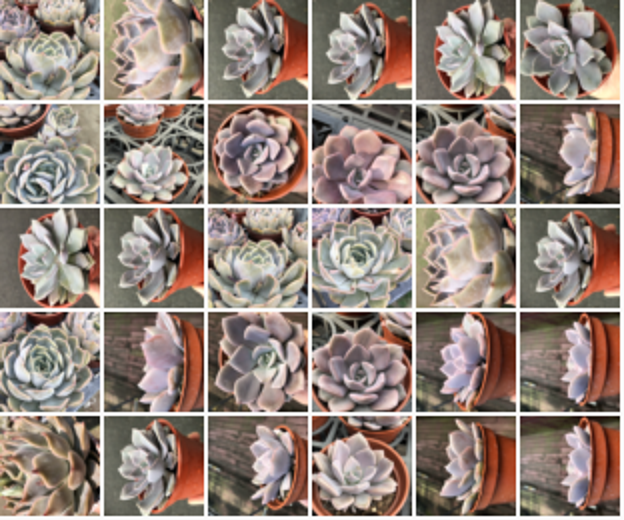

In [33]:
num_collage_examples = 5
height_width = 50

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = np.array(x_test_raw[row_idx][0])
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = np.array(x_test_raw[nn_idx][0])
show_collage(examples)

計算各類別中，每張圖片與最接近該圖片的類別是否為同一個，計算混淆矩陣

In [34]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')  

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2023-05-25 16:21:26--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.122.101, 172.253.122.139, 172.253.122.113, ...
Connecting to drive.google.com (drive.google.com)|172.253.122.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kd4o7e3cb1uvehsg5k7m9mr49m0fa9g5/1685031675000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=a2e26c08-8778-452d-86a1-c888fad6ded6 [following]
--2023-05-25 16:21:31--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kd4o7e3cb1uvehsg5k7m9mr49m0fa9g5/1685031675000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=a2e26c08-8778-452d-86a1-c888fad6ded6
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.163.132, 2607:f8b0:4004:c1b::84
Connecting to d

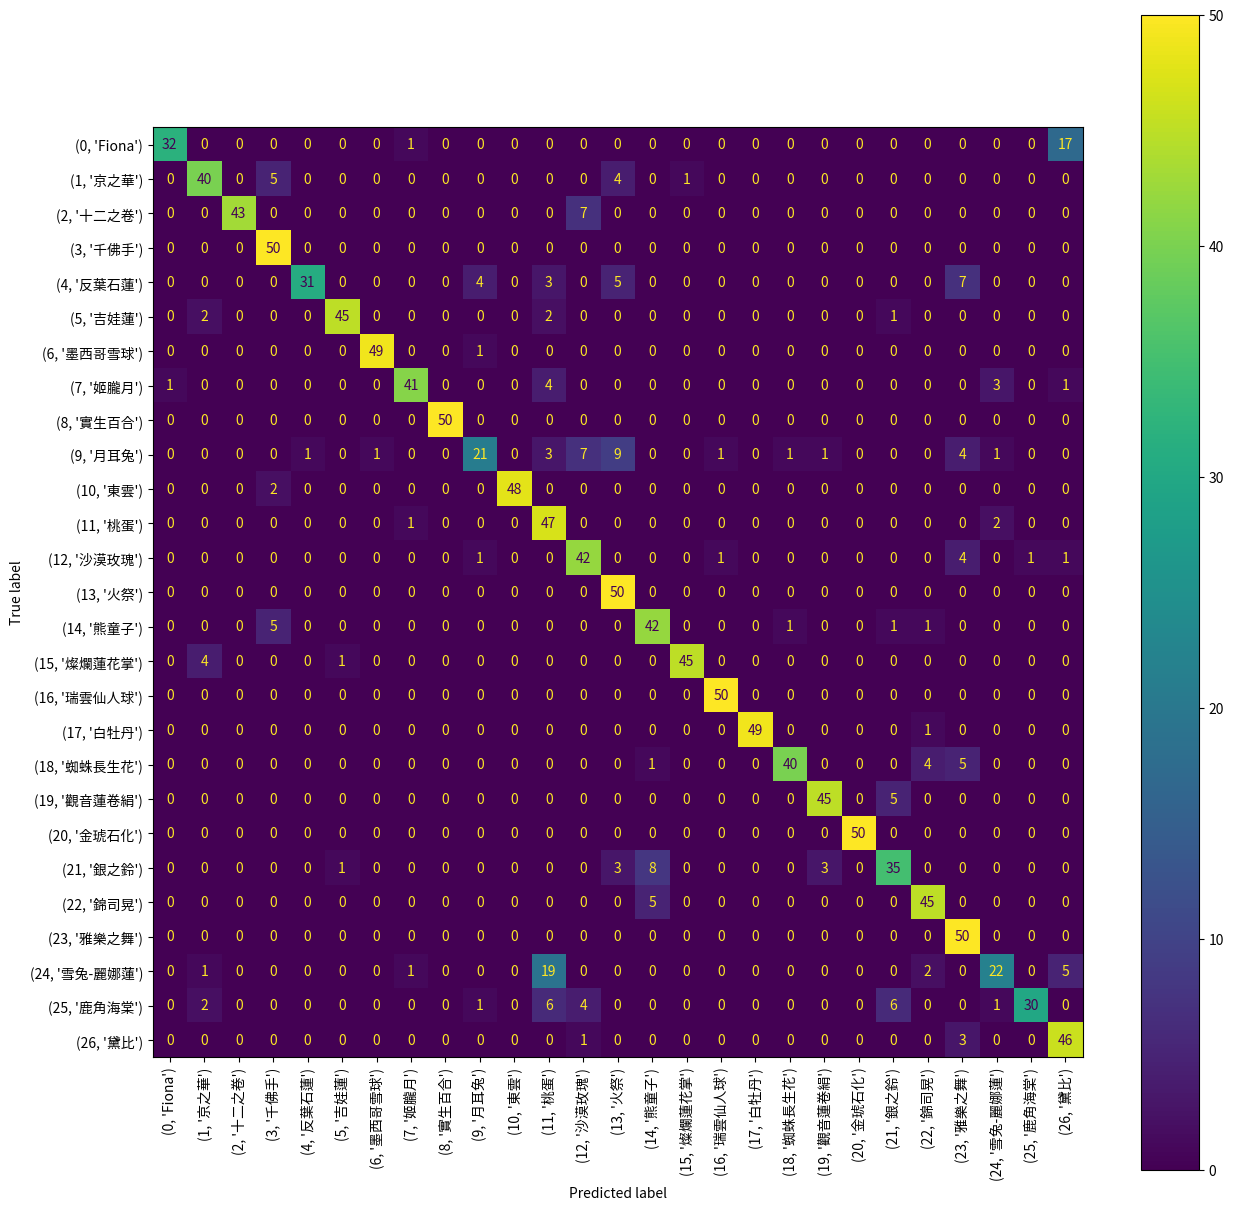

In [35]:

num_classes = 27

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
label_list = valid_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in label_list.items())

confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # 挑選10筆資料
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # 計算與該圖片最相似的圖片類別
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=cla_dict.items())
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()